In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import calc_vector
import multiprocessing as mp
import random
import tensorflow as tf

pd.set_option('display.max_columns', 100)

In [77]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

Files in DropBox for easy sharing Work and Personal laptop

In [123]:
path = '/Users/Robin/Dropbox/Data/'

## Amazon Fashion

In [ ]:
#Full data
# file_name = 'amazon_clothing_shoes_jewelry_data' 

#2m user above 5 ratings
# file_name = 'amazon_2m'

#0.63m user above 5 ratings
file_name = 'amazon_063m' 

## MovieLens

In [ ]:
# Full data
# file_name = '25m_ml'

# 2m subset
# file_name = '2m-ml'
# With 3.0 as rating threshold for a 1
# file_name = '2m-ml_3_r_thres'
# ml_07m subset
file_name = 'ml_0.7_u_above_5'

In [84]:
path = 'Data/'
df = pd.read_pickle(path + file_name)
df.head()

,user,item,rating,verified
0,A2OLY7TMIYHOQQ,B00EAKJUUW,5.0,True
1,A3F6ZP5VM8QUC6,B00D98EGE6,5.0,True
2,A21PFJA2O7Z5GY,B01DTEXSHA,2.0,True
3,AV9HIUYXBZODJ,B0045DBUBQ,3.0,True
4,A73X3PFCRTJVX,B00DEWBMU8,5.0,True


In [126]:
path = 'Data/'
df = pd.read_pickle(path + file_name)
df.head()

,user,item,rating,verified
0,A2OLY7TMIYHOQQ,B00EAKJUUW,5.0,True
1,A3F6ZP5VM8QUC6,B00D98EGE6,5.0,True
2,A21PFJA2O7Z5GY,B01DTEXSHA,2.0,True
3,AV9HIUYXBZODJ,B0045DBUBQ,3.0,True
4,A73X3PFCRTJVX,B00DEWBMU8,5.0,True


# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [ ]:
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

In [128]:
df.item_id.unique().max()

115062

## Leave item out train test split

In [87]:
def leave_x_out(full_data, leave_out):
    # Input: data must be formatted by func: tranfsorm
    # Output: full_data = without all entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    index_to_drop = []
    
    for indices in user_items_ind:
        if len(indices) > leave_out:
            for to_leave_out in range(leave_out):
                index = indices[- to_leave_out]
                index_to_drop.append(index)
    
    leave_one_out_set = full_data.loc[index_to_drop]
    full_data_leave_one_out = full_data.drop(index_to_drop)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_one_out_set.drop(columns=['index'])

In [88]:
def create_matrices(data, n_users, n_items):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(n_users, n_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones

In [89]:
train_set, test_set = leave_x_out(df, 2)
val_set, test_set = leave_x_out(test_set, 1)

In [90]:
print('Leave one item out per user',
      '\n\nFull Df length:\t\t', len(df),
      '\nTraining Set length:\t', len(train_set),
      '\nTesting Set length:\t', len(test_set),
      '\nValidation Set length:\t', len(val_set))

Leave one item out per user 

Full Df length:		 629889 
Training Set length:	 447457 
Testing Set length:	 91216 
Validation Set length:	 91216


# Model: BPR MF in TF

- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

---
## Init: Variables

In [91]:
total_users = len(df.user_id.unique())
total_items = len(df.item_id.unique())
latent_dim = 20
learning_rate = 0.1

n_epochs = 10

user_items = train_set.groupby('user_id')['item_id'].apply(list)
train_users = train_set.user_id.unique()
train_items = train_set.item_id.unique()

In [92]:
print('Total Users:', total_users,
      '\nTotal Items:', total_items)

Total Users: 91216 
Total Items: 115063


---
## Define Model, Loss, Train Step and Helpers

In [93]:
class BPR_MF(tf.keras.Model):
    def __init__(self, init_func, total_users, total_items, latent_dim): #b_init_func
        super(BPR_MF, self).__init__()
        self.p = tf.Variable(init_func(total_users, latent_dim), name="p")
        self.q = tf.Variable(init_func(total_items, latent_dim), name="q")
#         self.b = tf.Variable(b_init_func((total_items, 1)), name="b")
    
    def call(self, uij):
        return tf.math.multiply(self.p[uij[0]], (self.q[uij[1]] - self.q[uij[2]]))

In [94]:
class Loss:
    def __call__(self, x):
        return - tf.math.log_sigmoid(tf.math.reduce_sum(x))

In [95]:
@tf.function
def train_step(model, optimizer, uij):
    with tf.GradientTape(persistent=True) as tape:
        x = model(uij) 
        loss = loss_obj(x) # -x or not? 

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [96]:
def draw_sample(train_users, train_items, user_items):
    u = int(np.random.choice(train_users))
    u_items = user_items[u]
    i = random.choice(u_items)
    j = int(np.random.choice(train_items)) # neg item

    while j in u_items: # j cannot be the same item or an item with a 1
        j = int(np.random.choice(train_items))
        
    return tf.Variable([u, i, j])

In [119]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

---
# Train Model

## Init Model and Loss

In [97]:
normal_init = lambda v, d: tf.random.normal((v, d), 0.0, 1.0/d)
zero_init = lambda v: tf.zeros(v,1)

model = BPR_MF(normal_init, total_users, total_items, latent_dim)

In [98]:
loss_obj = Loss()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

---
## Train Loop

In [40]:
train_time_s = time.time()
total_losses = []
for epoch in tf.range(n_epochs):
    ep_time_s = time.time()
    ep_losses = []
    for sample in tf.range(len(train_set)):
        uij_sample = draw_sample(train_users, train_items, user_items)
        loss = train_step(model, optimizer, uij_sample)
        
        ep_losses.append(loss)
    ep_loss = np.average(ep_losses)
    
    print('Epoch:', epoch.numpy(), '\tLoss:', round(ep_loss,4), '\tEpoch Time:', time.time() - ep_time_s)
    total_losses.append(ep_loss)

print('Total training time:', time.time() - train_time_s)

Epoch: 0 	Loss: 0.6867 	Epoch Time: 2789.7120835781097
Epoch: 1 	Loss: 0.5903 	Epoch Time: 2788.5875730514526
Epoch: 2 	Loss: 0.3808 	Epoch Time: 2785.1623594760895
Epoch: 3 	Loss: 0.2653 	Epoch Time: 2813.3431804180145
Epoch: 4 	Loss: 0.2181 	Epoch Time: 2780.731358528137
Epoch: 5 	Loss: 0.1899 	Epoch Time: 2754.6160719394684
Epoch: 6 	Loss: 0.169 	Epoch Time: 2757.2164154052734
Epoch: 7 	Loss: 0.1542 	Epoch Time: 2773.1963369846344
Epoch: 8 	Loss: 0.1407 	Epoch Time: 2755.1128487586975
Epoch: 9 	Loss: 0.1296 	Epoch Time: 2754.849689245224
Total training time: 27752.541813850403


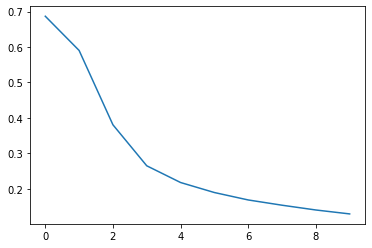

In [41]:
plt.plot(total_losses)
plt.show()

---
## Quick np save

In [42]:
np.savetxt('Results/BPR_TF/p.txt', model.p.numpy(), fmt='%f')
np.savetxt('Results/BPR_TF/q.txt', model.q.numpy(), fmt='%f')


p = np.loadtxt('Results/BPR_TF/p.txt', dtype=float)
q = np.loadtxt('Results/BPR_TF/q.txt', dtype=float)

# Evaluate Model

In [43]:
train_set.to_pickle('Results/BPR_TF/train_set')
test_set.to_pickle('Results/BPR_TF/test_set')

In [44]:
train_set = pd.read_pickle('Results/BPR_TF/train_set')
test_set = pd.read_pickle('Results/BPR_TF/test_set')

In [45]:
np.dot(p[0],q[0].T)

4.271967854879

In [5]:
import eval_rank_bpr
result = {'p':p, 'q':q}
users = test_set.user_id.unique()
items = test_set.item_id.unique()
test_user_items = test_set.groupby('user_id')['item_id'].apply(list)

s = time.time()
rank_at = 20
mp_splits = 4
users_split = np.array_split(users, mp_splits)

In [6]:
eval_rank_bpr.eval_rank_bpr([result, users_split[0], items, test_user_items, rank_at])

,scores_ranked,pred_items_ranked,true_id
1,"(0.782769451433, 0.743779667441, 0.73484823437...","(294, 242, 3710, 451, 4540, 836, 5274, 841, 19...",[3403]
12,"(1.1382500490260001, 0.9098205844179998, 0.825...","(472, 0, 3505, 1781, 239, 429, 833, 18, 3854, ...",[2541]
30,"(1.244876958548, 1.118842594111, 1.05777020205...","(2022, 1100, 4211, 546, 2491, 5543, 1126, 116,...",[840]
39,"(1.382680892857, 1.256073012007, 0.87326090753...","(1919, 2022, 4211, 903, 3505, 1074, 118, 276, ...",[1088]
50,"(2.284304490758, 1.677254996362, 1.53095557457...","(238, 294, 466, 469, 1100, 763, 2241, 2775, 32...",[427]
...,...,...,...
8382,"(1.404969001027, 1.3350839652889999, 1.2104916...","(1074, 833, 849, 95, 614, 3281, 1613, 1302, 13...",[6127]
8383,"(2.877398222098, 2.557897541755, 2.26984983106...","(759, 482, 4066, 2491, 5543, 1655, 1171, 2241,...",[4254]
8386,"(1.058857749812, 0.9896739806879999, 0.7897804...","(44, 441, 1388, 301, 3470, 1133, 2491, 470, 45...",[6059]
8387,"(1.856431028364, 1.1526715260549998, 1.1026409...","(1919, 2022, 242, 472, 2222, 386, 873, 3303, 9...",[998]


In [11]:
type(test_set)

pandas.core.frame.DataFrame

In [46]:
import eval_rank_bpr
result = {'p':p, 'q':q}
users = test_set.user_id.unique()
items = test_set.item_id.unique()
test_user_items = test_set.groupby('user_id')['item_id'].apply(list)

s = time.time()
rank_at = 20
mp_splits = 4
users_split = np.array_split(users, mp_splits)
        
if __name__ == '__main__':
    pool = mp.Pool(processes = mp_splits)
    ranked = pool.map(eval_rank_bpr.eval_rank_bpr, [[result, users_split[0], items, test_user_items, rank_at], 
                                            [result, users_split[1], items, test_user_items, rank_at], 
                                            [result, users_split[2], items, test_user_items, rank_at], 
                                            [result, users_split[3], items, test_user_items, rank_at]])
    pool.close()
    
    ranked_df = pd.DataFrame()

    for i in range(mp_splits):
        ranked_df = pd.concat([ranked_df, ranked[i]])
        
    t = time.time() - s
    print(t/60)

17.91136803627014


In [47]:
steps = 5
ranks_at = [1] + [i for i in range(steps, rank_at + steps, steps)]

In [48]:
ranks_at

[1, 5, 10, 15, 20]

In [49]:
len(users)

54277

In [50]:
ranked_df

,scores_ranked,pred_items_ranked,true_id
0,"(11.096968328988, 9.790216473669, 9.3872448929...","(875, 4634, 342, 416, 1504, 3142, 725, 223, 68...",[4842]
1,"(9.070790855216, 8.254116944099, 7.70535786749...","(3330, 3274, 725, 3740, 3136, 3132, 1338, 1816...",[4073]
2,"(10.480868196541998, 8.86418392492, 8.75772140...","(4997, 6305, 7048, 230, 2955, 853, 4178, 6453,...",[8406]
3,"(7.813343638447001, 6.992423157903, 6.43505922...","(939, 452, 320, 146, 20, 955, 9, 900, 929, 974...",[297]
4,"(8.511280315242999, 8.301163375839002, 8.18785...","(0, 293, 939, 2033, 283, 126, 900, 445, 4178, ...",[523]
...,...,...,...
54272,"(8.741283549908001, 8.289856669636, 8.12622371...","(6880, 2301, 283, 3792, 623, 535, 858, 521, 10...",[2527]
54273,"(7.784468629646, 7.5277180533150005, 7.4389892...","(3784, 875, 230, 4634, 4279, 2301, 2033, 1771,...",[9333]
54274,"(6.225381308359999, 5.8081412444869995, 5.3706...","(282, 32, 320, 97, 7789, 2256, 179, 141, 3330,...",[2560]
54275,"(9.066234802238, 7.814730784342, 6.96329663954...","(425, 521, 853, 4556, 313, 3806, 7048, 230, 19...",[6386]


In [51]:
hitcounts = []
recs_at = []
precs_at = []
for rank in ranks_at:
    hitcount = 0
    for u in ranked_df.index:
        hitcount +=  len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked'][:rank]))
                    
    prec_at = hitcount / rank / len(ranked_df)
    rec_at = hitcount / len(ranked_df.iloc[0]['true_id']) / len(ranked_df)
    
    print('rank_at:', rank, '  Hits:', hitcount)
    hitcounts.append(hitcount)                     
    recs_at.append(rec_at)
    precs_at.append(prec_at)

rank_at: 1   Hits: 117
rank_at: 5   Hits: 495
rank_at: 10   Hits: 912
rank_at: 15   Hits: 1343
rank_at: 20   Hits: 1736


In [53]:
hitcounts

[117, 495, 912, 1343, 1736]

In [52]:
file_name

'ml_0.7_u_above_5'

In [69]:
bpr_tf = pd.DataFrame(columns=['rank_at', 'hitcounts', 'recall', 'precision'])

In [70]:
bpr_tf

,rank_at,hitcounts,recall,precision


In [71]:
bpr_tf['rank_at'] = ranks_at
bpr_tf['hitcounts'] = hitcounts
bpr_tf['recall'] = recs_at
bpr_tf['precision'] = precs_at

In [72]:
bpr_tf

,rank_at,hitcounts,recall,precision
0,1,117,0.002156,0.002156
1,5,495,0.009120,0.001824
2,10,912,0.016803,0.001680
3,15,1343,0.024743,0.001650
4,20,1736,0.031984,0.001599


In [107]:
path = 'C:/Users/robin.opdam/Dropbox'

In [108]:
bpr_tf.to_pickle(path + '/Results/BPR_TF/' + file_name + '_tf_res')